# Notebook pour tester le bibliothèque Detectron 2 

### Installation et imports

In [1]:
! python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-v9zjok27
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-v9zjok27
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"
! PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [3]:
import torch, detectron2, cv2

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
print('cv2', cv2.__version__)

torch:  2.5 ; cuda:  cu124
detectron2: 0.6
cv2 4.10.0


In [4]:
from detectron2.utils.logger import setup_logger
setup_logger(color=True)

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
base_path = '../raw_data/public_training_set_release_2.0/images/'

In [6]:
import json
from collections import defaultdict
import random

# Charger le fichier JSON
with open("../raw_data/public_training_set_release_2.0/annotations.json", "r") as f:
    data = json.load(f)

# Compter le nombre d'annotations par image
image_annotation_count = defaultdict(int)
for annotation in data["annotations"]:
    image_annotation_count[annotation["image_id"]] += 1

# Filtrer les images avec 1 ou 2 annotations
filtered_image_ids = {image_id for image_id, count in image_annotation_count.items() if count in [1, 2]}

# Ajouter 20 images avec 3 annotations
three_annotation_images = [image_id for image_id, count in image_annotation_count.items() if count == 3]
filtered_image_ids.update(random.sample(three_annotation_images, min(100, len(three_annotation_images))))

# Ajouter 20 images avec 4 annotations
four_annotation_images = [image_id for image_id, count in image_annotation_count.items() if count == 4]
filtered_image_ids.update(random.sample(four_annotation_images, min(50, len(four_annotation_images))))

# Créer les nouvelles sections filtrées
filtered_images = [img for img in data["images"] if img["id"] in filtered_image_ids]
filtered_annotations = [anno for anno in data["annotations"] if anno["image_id"] in filtered_image_ids]

# Conserver uniquement les catégories utilisées
used_category_ids = {anno["category_id"] for anno in filtered_annotations}
filtered_categories = [cat for cat in data["categories"] if cat["id"] in used_category_ids]

# Construire le nouveau dataset
filtered_data = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": filtered_categories,
    "info": data.get("info", {}),
    "licenses": data.get("licenses", [])
}

# Sauvegarder le nouveau fichier JSON
with open("filtered_annotations.json", "w") as f:
    json.dump(filtered_data, f)

print(f"Dataset filtré avec {len(filtered_images)} images, dont :")
print(f"- {len([img for img in filtered_images if image_annotation_count[img['id']] == 1])} avec 1 annotation")
print(f"- {len([img for img in filtered_images if image_annotation_count[img['id']] == 2])} avec 2 annotations")
print(f"- 100 avec 3 annotations")
print(f"- 50 avec 4 annotations")

Dataset filtré avec 31166 images, dont :
- 23134 avec 1 annotation
- 7882 avec 2 annotations
- 100 avec 3 annotations
- 50 avec 4 annotations


In [7]:
from detectron2.data.datasets import register_coco_instances
# dataset -- validation
register_coco_instances("food/train", {},
                        "../raw_data/public_training_set_release_2.0/filtered_annotations.json",
                        "../raw_data/public_training_set_release_2.0/images")

# dataset -- validation
register_coco_instances("food/val", {},
                        "../raw_data/public_validation_set_2.0/annotations.json",
                        "../raw_data/public_validation_set_2.0/images")

In [8]:
train_metadata = MetadataCatalog.get('food/train')
train = DatasetCatalog.get('food/train')

[11/27 17:27:25 d2.data.datasets.coco]: Loading ../raw_data/public_training_set_release_2.0/filtered_annotations.json takes 1.37 seconds.
WARNING [11/27 17:27:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/27 17:27:25 d2.data.datasets.coco]: Loaded 31166 images in COCO format from ../raw_data/public_training_set_release_2.0/filtered_annotations.json


In [9]:
val_metadata = MetadataCatalog.get('food/val')
val = DatasetCatalog.get('food/val')

WARNING [11/27 17:27:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/27 17:27:25 d2.data.datasets.coco]: Loaded 1000 images in COCO format from ../raw_data/public_validation_set_2.0/annotations.json


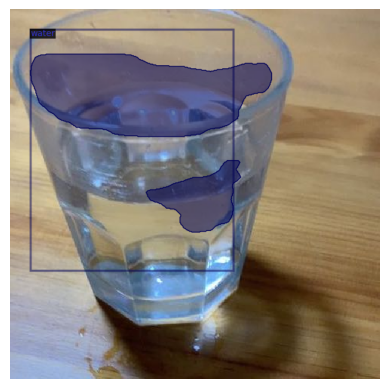

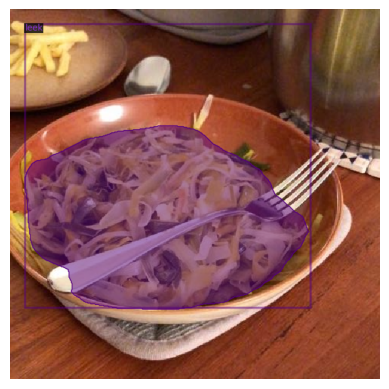

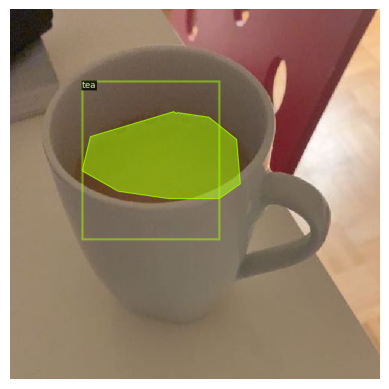

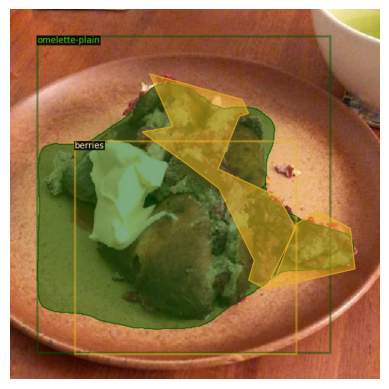

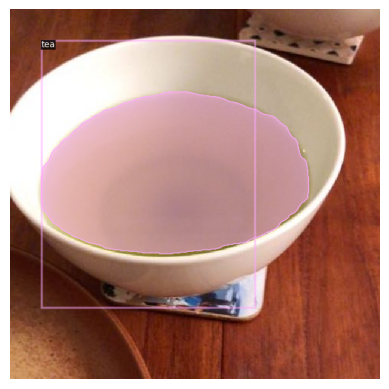

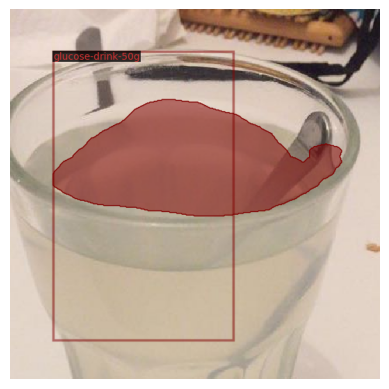

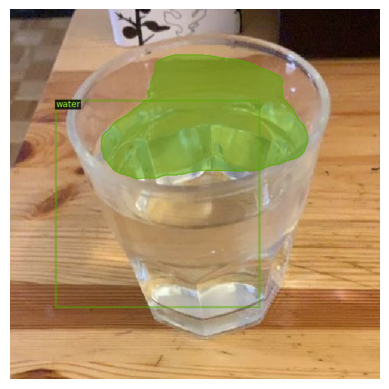

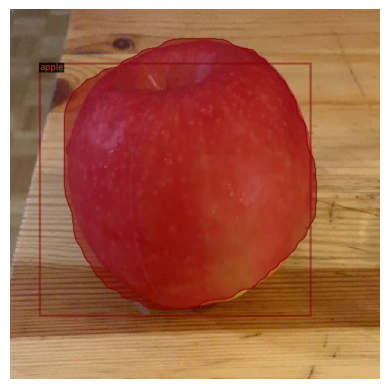

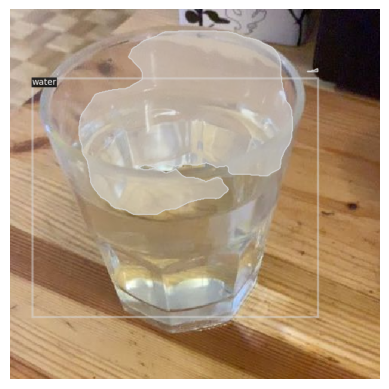

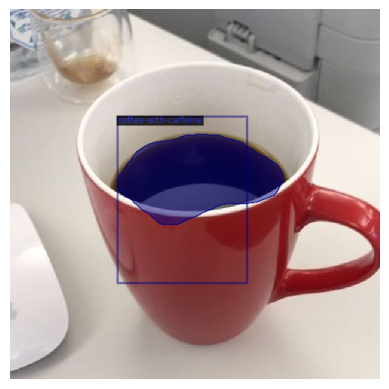

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

for im in train[120:130]:
    img = Image.open(im['file_name'])
    visualizer = Visualizer(img, scale=1.25, metadata=train_metadata)
    out = visualizer.draw_dataset_dict(im)
    plt.imshow(out.get_image())
    plt.axis('off')
    plt.show()

In [11]:
from detectron2.engine import DefaultTrainer
import torch

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('food/train', )
cfg.DATASETS.VAL = ('food/val', )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.025
cfg.SOLVER.MAX_ITER = 512
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 800
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

cfg.OUTPUT_DIR = './output'


torch.cuda.empty_cache()

In [12]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/27 17:27:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (499, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (499,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (1992, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (1992,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score

[11/27 17:27:31 d2.engine.train_loop]: Starting training from iteration 0
ERROR [11/27 17:27:32 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/sdelannoy/.pyenv/versions/3.10.6/envs/foodbuddys/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/sdelannoy/.pyenv/versions/3.10.6/envs/foodbuddys/lib/python3.10/site-packages/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/home/sdelannoy/.pyenv/versions/3.10.6/envs/foodbuddys/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/home/sdelannoy/.pyenv/versions/3.10.6/envs/foodbuddys/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/sdelannoy/.pyenv/versions/3.10.6/envs/foodbuddys/lib/python3.10/site-packages/torch/nn

OutOfMemoryError: CUDA out of memory. Tried to allocate 238.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 172.31 MiB is free. Including non-PyTorch memory, this process has 5.59 GiB memory in use. Of the allocated memory 5.46 GiB is allocated by PyTorch, and 30.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)